In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

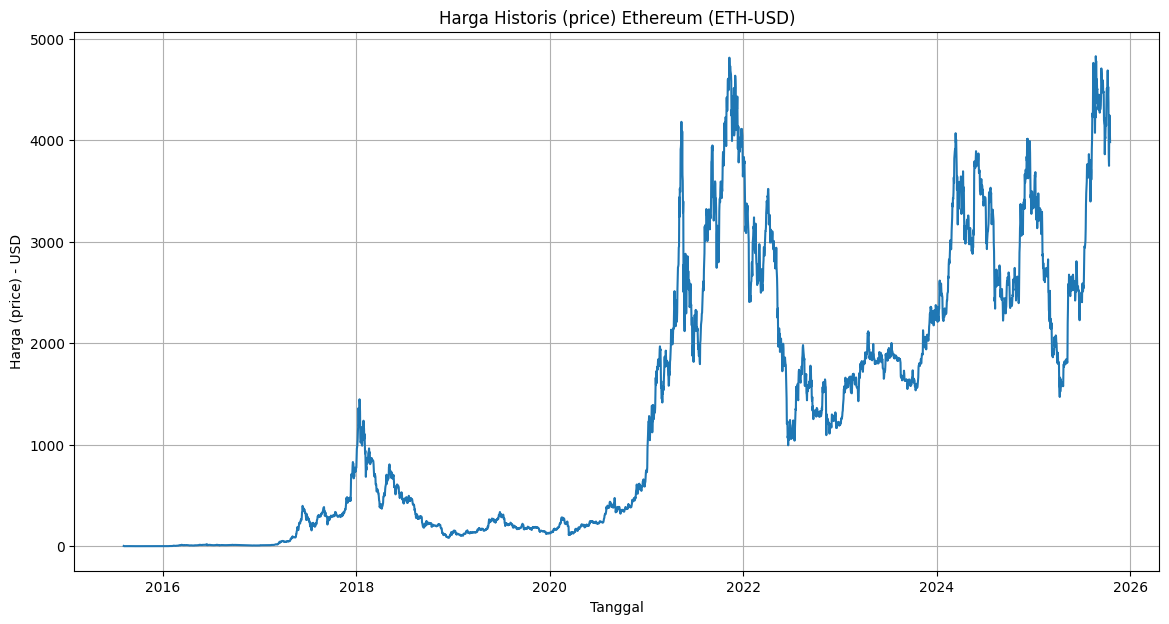

In [15]:
# --- 1. Memuat dan Membersihkan Data ---
filename = 'eth-usd-max.csv'
df = pd.read_csv(filename)

# Konversi kolom waktu menjadi tipe datetime dan set sebagai index
# Kolom waktu dalam dataset ini adalah 'snapped_at'
df['snapped_at'] = pd.to_datetime(df['snapped_at'])
df.set_index('snapped_at', inplace=True)

# Urutkan data berdasarkan tanggal
df.sort_index(inplace=True)

# Kita akan memprediksi harga ('price')
feature_column = 'price' # Kolom target yang akan diprediksi
target_data = df[[feature_column]]

# Visualisasi awal data historis
plt.figure(figsize=(14, 7))
plt.title(f'Harga Historis ({feature_column}) Ethereum (ETH-USD)')
plt.plot(target_data[feature_column])
plt.xlabel('Tanggal')
plt.ylabel(f'Harga ({feature_column}) - USD')
plt.grid(True)
plt.show()

In [16]:
# --- 2. Pra-Pemrosesan Data ---
# Ambil nilai-nilai dari kolom target
values = target_data.values

# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

In [17]:
# --- 3. Membuat Struktur Data Sekuensial (Windowing) ---
timesteps = 60 # Jumlah hari historis untuk memprediksi satu hari ke depan

X = []
y = []

for i in range(timesteps, len(scaled_values)):
    X.append(scaled_values[i-timesteps:i, 0]) # Fitur historis sebanyak timesteps
    y.append(scaled_values[i, 0])             # Nilai target (harga di hari ke-i)

X, y = np.array(X), np.array(y)

# Reshape data untuk input ke LSTM: (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [18]:
# --- 4. Membagi Data menjadi Latih dan Uji ---
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Jumlah data latih: {len(X_train)}")
print(f"Jumlah data uji: {len(X_test)}")

Jumlah data latih: 2930
Jumlah data uji: 733


In [19]:
# --- 5. Membangun dan Melatih Model LSTM ---
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Latih model
epochs = 25
batch_size = 32

# Baris ini yang sebelumnya menyebabkan error, pastikan lengkap
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)


Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.0111 - val_loss: 0.0024
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 9.3015e-04 - val_loss: 0.0013
Epoch 8/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 9/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 9.5310e-04 - val_loss: 0.0012
Epoch 10/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 8.3426e-04 - val_loss: 0.0025
Epoch 11/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 9.3043e-04 - val_loss: 0.0011
Epoch 12/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


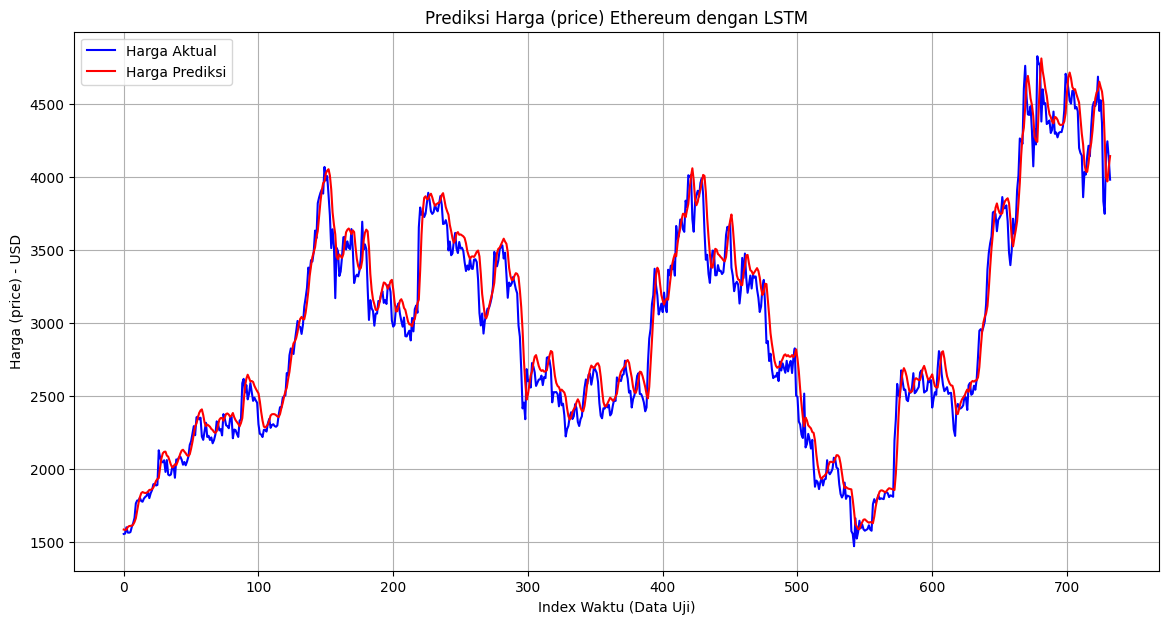


Nilai Root Mean Squared Error (RMSE) pada data uji: $144.16
Nilai Mean Squared Error (MSE) pada data uji: $20780.72


In [22]:
# --- 6. Evaluasi dan Visualisasi Hasil ---
# Lakukan prediksi pada data uji
predictions_scaled = model.predict(X_test)

# Kembalikan prediksi dan data uji ke skala aslinya
predictions = scaler.inverse_transform(predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot hasil prediksi vs data aktual
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color='blue', label='Harga Aktual')
plt.plot(predictions, color='red', label='Harga Prediksi')
plt.title(f'Prediksi Harga ({feature_column}) Ethereum dengan LSTM')
plt.xlabel('Index Waktu (Data Uji)')
plt.ylabel(f'Harga ({feature_column}) - USD')
plt.legend()
plt.grid(True)
plt.show()

# Hitung RMSE dan MSE
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mse = mean_squared_error(y_test_actual, predictions)
print(f"\nNilai Root Mean Squared Error (RMSE) pada data uji: ${rmse:.2f}")
print(f"Nilai Mean Squared Error (MSE) pada data uji: ${mse:.2f}")


In [23]:
import json

# --- 7. Simpan Model dan Informasi Pelatihan ---
# Simpan model ke file
model.save("ethereum_price_lstm_model.h5")
print("\nModel telah disimpan sebagai 'ethereum_price_lstm_model.h5'")

# Buat tabel informasi pelatihan
training_info = {
    "model_name": "Ethereum_Price_LSTM_Prediction",
    "target_feature": feature_column,
    "timesteps": timesteps,
    "epochs": epochs,
    "batch_size": batch_size,
    "train_size": len(X_train),
    "test_size": len(X_test),
    "rmse": float(rmse),
    "mse": float(mse),
    "architecture": str(model.summary())
}

# Simpan informasi pelatihan ke file JSON
with open("model_training_info.json", "w") as f:
    json.dump(training_info, f, indent=4)

print("Informasi pelatihan model telah disimpan sebagai 'model_training_info.json'")

# Tampilkan ringkasan arsitektur model
print("\n--- Ringkasan Arsitektur Model LSTM ---")
model.summary()


Model telah disimpan sebagai 'ethereum_price_lstm_model.h5'


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

Informasi pelatihan model telah disimpan sebagai 'model_training_info.json'

--- Ringkasan Arsitektur Model LSTM ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)